# 0. Set working directory  

In [1]:
setwd("C:/Users/JChong/Downloads")

# 1. Load data and transform into time series object 

In [2]:
# Read and view data 
testing.stationarity  = read.table("testing.stationarity.txt")
head(testing.stationarity)
str(testing.stationarity)

V1
0.9314654
1.3201530
2.1054025
2.3904040
5.2749129
5.5462100


'data.frame':	365 obs. of  1 variable:
 $ V1: num  0.931 1.32 2.105 2.39 5.275 ...


In [3]:
# Transform data into time series object 
testing.stationarity = ts(testing.stationarity)
head(testing.stationarity)
str(testing.stationarity)

[1] 0.9314654 1.3201530 2.1054025 2.3904040 5.2749129 5.5462100

 Time-Series [1:365, 1] from 1 to 365: 0.931 1.32 2.105 2.39 5.275 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr "V1"


# 2. Testing stationarity

Stationarity is an important concept in time series analysis. Most time series models such as ARIMA, which we will explore later, assume that each data point is independent of one another. In other words, before we can fit a time series model to the data and use the model to make predictions, we need to first ensure that the time series is stationary. 

A time series is considered stationary if it satisifies the following 3 conditions: 
1. The expected value (mean) is constant over time 
2. The volatility (variance) of the time series is constant around its mean over time 
3. The covariance of the time series depends only on the time lag 

Visually speaking, there are two components to a time series that determine whether or not it is stationary: trend and seasonality.

Trend is the long-term increase or decrease in the time series over a period of time. For example, the stock market such as the S&P500 index has seen an overall increasing trend over the last few decades.

Seasonality, on the other hand, represents a recurring pattern that happens at a fixed and known frequency. For example, annual retail sales tend to have spikes in the month of December due to holiday shopping during the Christmas season.

Before we look at how to remove trends and seasonality from a time series, let us first examine how to test for stationarity in a particular time series. Here, I have demonstrated 2 methods: 
1. Phillips-Perron Unit Root Test
2. Plotting the sample ACF of the time series


	Phillips-Perron Unit Root Test

data:  testing.stationarity
Dickey-Fuller = -1.9639, Truncation lag parameter = 5, p-value = 0.5922


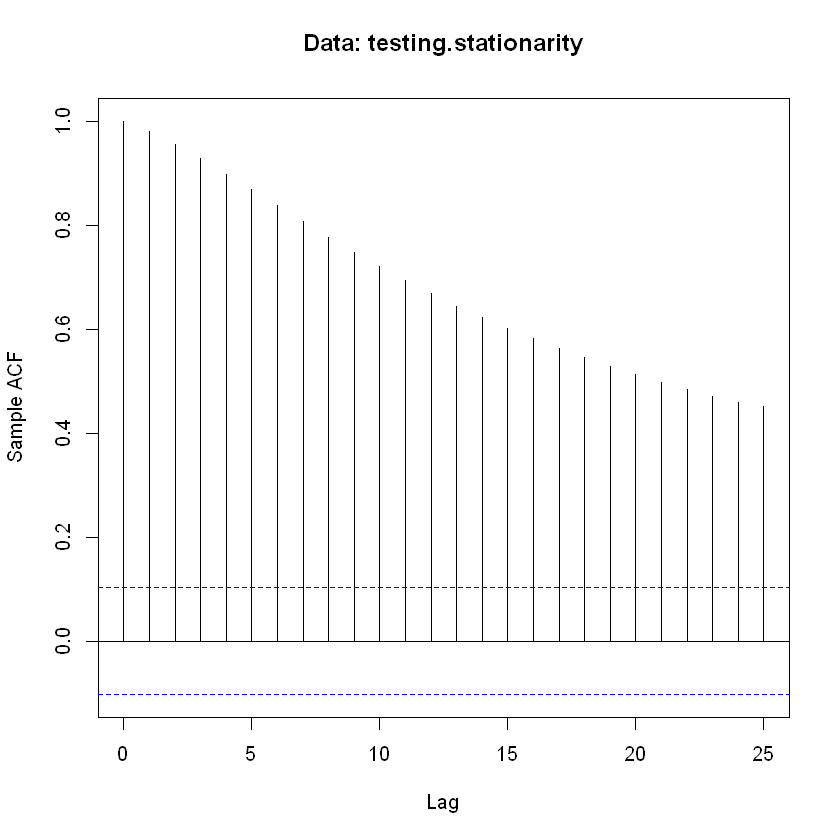

In [4]:
# Plot sample ACF and perform unit root test on time series data 
acf(testing.stationarity, main="Data: testing.stationarity", ylab="Sample ACF")
PP.test(testing.stationarity)

ACF decays slowly which indicates that the time series is not stationary. Furthermore, p-value from PP.test is greater than 0.05, therefore we do not reject the null hypothesis and conclude that the process needs to be differenced.

# 3. Removing trend

There are a lot of ways to remove trend from a time series. Here, I have 2 of the simplest methods:
1. Differencing 
2. Least square trends removal 

Differencing simply means finding the difference between the data point and a previous data point of a given lag. Least square trends removal, on the other hand, involves fitting a linear model to the time series and subtracting the fitted values from the data points.  

## 3.1 Differencing

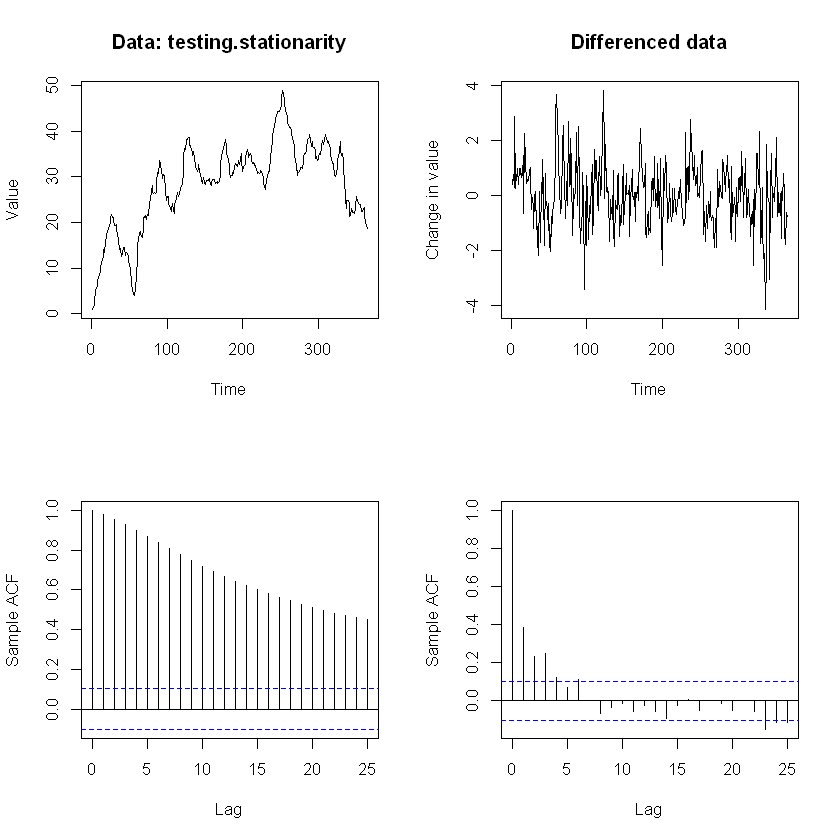

In [5]:
# Difference data using lag=1 and differences=1
Xt = diff(testing.stationarity, lag=1, differences=1)

# Plot original data, differenced data, and their respective sample ACFs 
par(mfrow=c(2,2))
ts.plot(testing.stationarity, main="Data: testing.stationarity",
        ylab="Value")
ts.plot(Xt, main="Differenced data", ylab="Change in value")
acf(testing.stationarity, main="", ylab="Sample ACF")
acf(Xt, main="", ylab="Sample ACF")
par(mfrow=c(1,1))

In [6]:
# Perform unit root test on differenced data 
PP.test(Xt)


	Phillips-Perron Unit Root Test

data:  Xt
Dickey-Fuller = -13.204, Truncation lag parameter = 5, p-value = 0.01


We have successfully removed trend from the time series. P-value in the differenced data suggests that we should reject the null hypothesis and conclude that the process does not need to be differenced again. 

## 3.1.1 Choosing the number of times to difference data

To determine the number of times to difference a time series, we can choose the one that gives us the lowest overall variance.  

diff,var
0,89.786497
1,1.275450
2,1.567230
3,4.320507
4,13.731510
5,46.247357
6,160.897967
7,571.637791


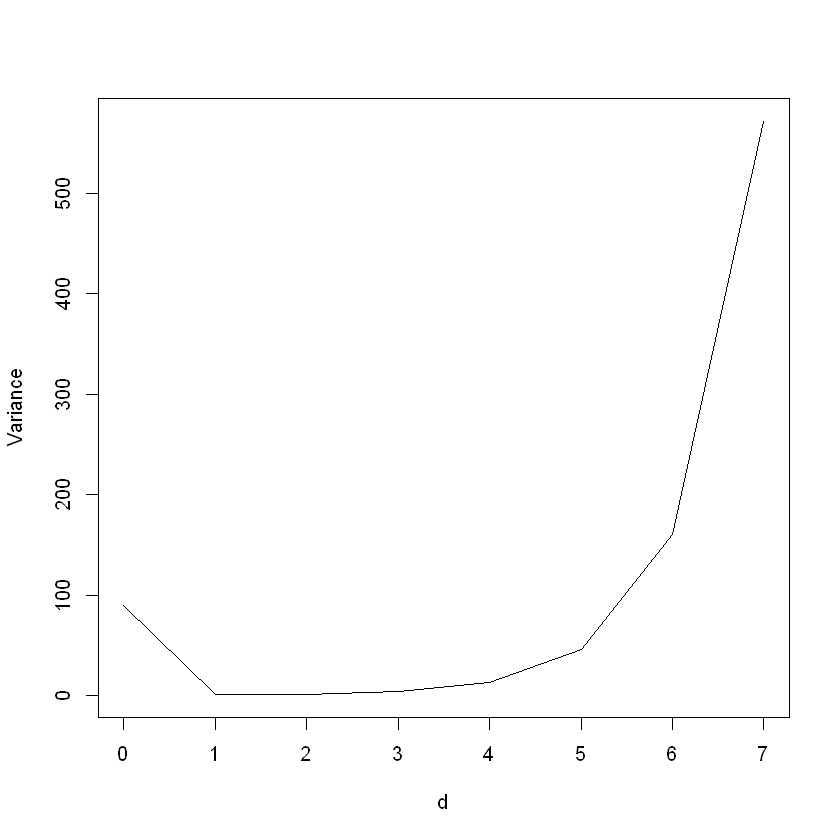

In [7]:
# Try difference values between 0-7 and store their respective variance as a data frame 
ts.var = var(testing.stationarity)
for(i in 1:7) {
  diff = diff(testing.stationarity, lag=1, differences = i)
  ts.var[i+1] = var(diff)
}
ts.var.df = data.frame(diff=0:7, var=ts.var)
ts.var.df

# Plot variance against the number of times data is differenced 
plot(ts.var.df, type="l", ylab="Variance", xlab="d")

Variance is lowest when process is differenced only once, and increases subsequently. Therefore, we conclude that the data should not be differenced a second time. 

## 3.2 Least squares trend removal 

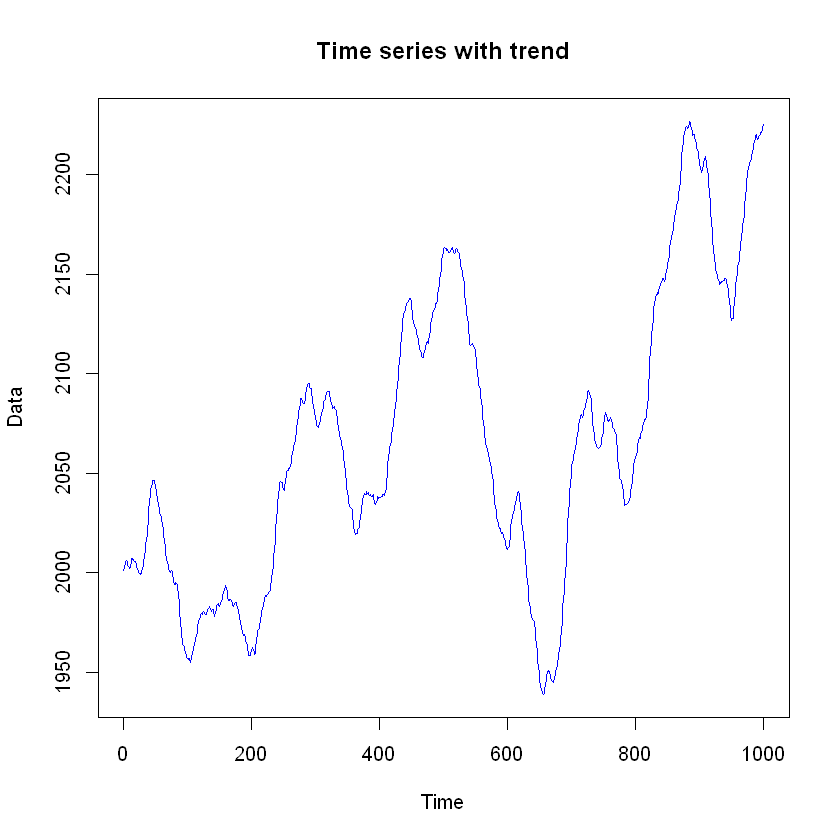

In [8]:
# Generate time series data 
set.seed(123)
n = 1000
sim = arima.sim(list(ar=0.9), n)
xt = 2000+cumsum(sim)

# Plot generated time series 
ts.plot(xt, col="blue", main="Time series with trend", ylab="Data")

We can see that the simulated time series has an overall increasing trend. To remove this trend, we will fit a linear model to the data and subtract the fitted values from the data points to obtain the residuals.

If done properly, the residuals should have no more trend i.e. have a constant mean over time. 

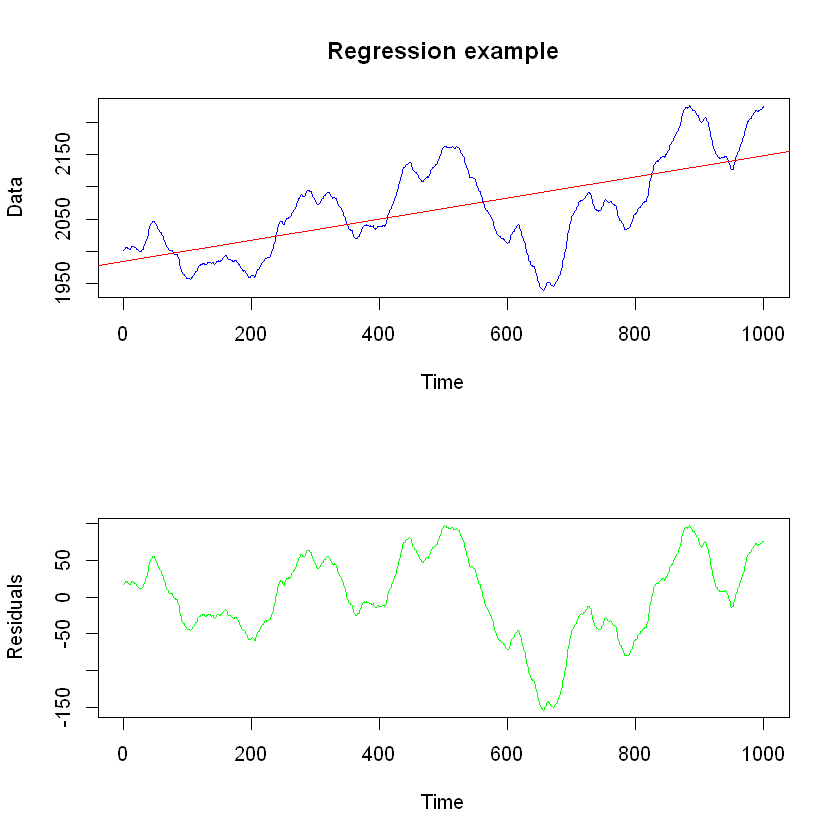

In [9]:
# Fit a linear model on time series, extract fitted values and residuals 
time = time(xt)
fit = lm(xt ~ time)
yt = fit$fitted.values
zt = fit$residuals

# Plot time series with superimposed linear model and residuals 
par(mfrow=c(2,1))
ts.plot(xt, col="blue", main="Regression example", ylab="Data")
abline(fit, col="red")
plot(xt-yt, type="l", col="green", xlab="Time", ylab="Residuals")
par(mfrow=c(1, 1))

# 4. Removing seasonality 

Similar to trends, there are multiple ways to remove seasonality. Here, I have shown 3 methods:
1. Seasonal differencing 
2. Seasonal means 
3. Method of moving averages using built-in R function 

Seasonal differencing means to subtract each data point by a previous data point of a fixed lag. Seasonal means involves subtracting each data point by their respective group averages, for example, monthly averages. Lastly, method of moving averages involves calculating the trend of a time series by taking the moving average over the entire time series. 

## 4.1 Introduction to the ldeaths dataset in R 

ldeaths represent monthly deaths from bronchitis, emphysema and asthma in the UK between the years 1974-1979, for both males and females. 

In [10]:
# View ldeaths dataset documentation 
# help("ldeaths")

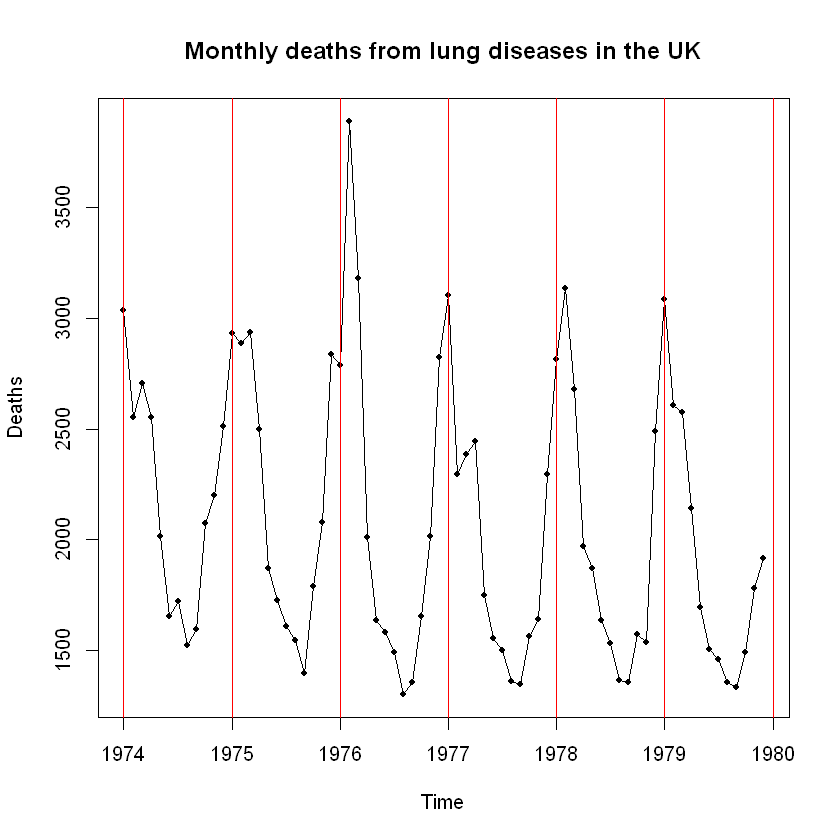

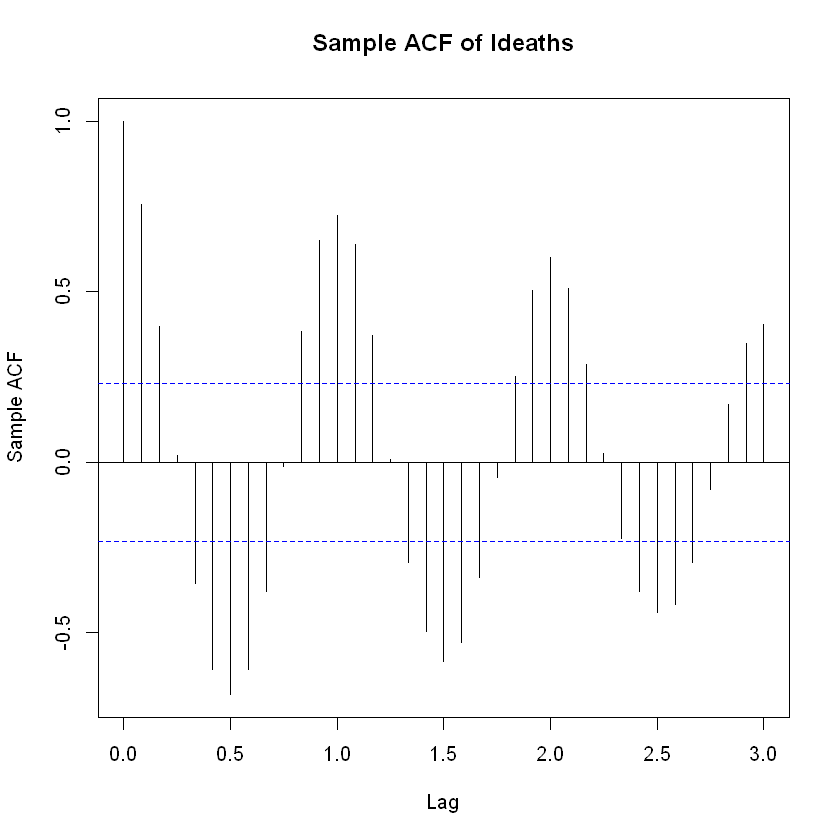

In [11]:
# Plot ldeaths 
plot(ldeaths, main="Monthly deaths from lung diseases in the UK", ylab="Deaths")
points(ldeaths, pch=20)

# Add red vertical line at the start of each year  
abline(v=1974:1980, col="red")

# Plot sample ACF of ldeaths 
acf(ldeaths, main="Sample ACF of ldeaths", ylab="Sample ACF", lag.max=36)

The chart appears to show a yearly seasonal effect. Although the highest point each year is not necessarily always in the same month, however, there is still a visible annual trend that is present in the data. 

## 4.2 Seasonal differencing 

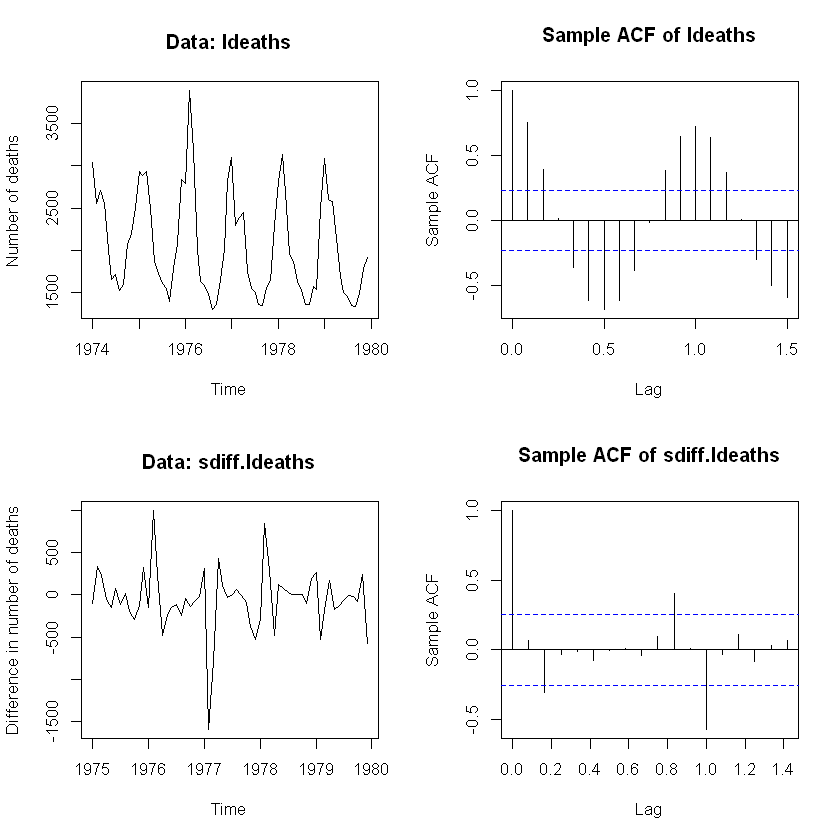

In [12]:
# Difference ldeaths using lag=12 i.e. January 1975 minus January 1974, February 1975 minus February 1974, and so on 
sdiff.ldeaths = diff(ldeaths, lag=12, differences=1)

# Plot original data, differenced data, and their respective sample ACFs   
par(mfrow=c(2,2))
ts.plot(ldeaths, main="Data: ldeaths", ylab="Number of deaths")
acf(ldeaths, main="Sample ACF of ldeaths", ylab="Sample ACF")
ts.plot(sdiff.ldeaths, main="Data: sdiff.ldeaths", ylab="Difference in number of deaths")
acf(sdiff.ldeaths, main="Sample ACF of sdiff.ldeaths", ylab="Sample ACF")
par(mfrow=c(1,1))

## 4.3 Seasonal means 

In [13]:
# Generate ldeaths as dataframe 
ldeaths.df = data.frame(year=rep(1974:1979, each=12),
                        month=rep(1:12, 6),
                        value=ldeaths)
head(ldeaths.df, 12)

year,month,value
1974,1,3035
1974,2,2552
1974,3,2704
1974,4,2554
1974,5,2014
1974,6,1655
1974,7,1721
1974,8,1524
1974,9,1596
1974,10,2074


In [14]:
# Monthly averages of ldeaths dataset 
xbars = aggregate(value ~ month, data = ldeaths.df, mean)
xbars

month,value
1,2959.333
2,2894.667
3,2743.000
4,2269.667
5,1805.167
6,1608.667
7,1550.833
8,1408.333
9,1397.333
10,1690.000


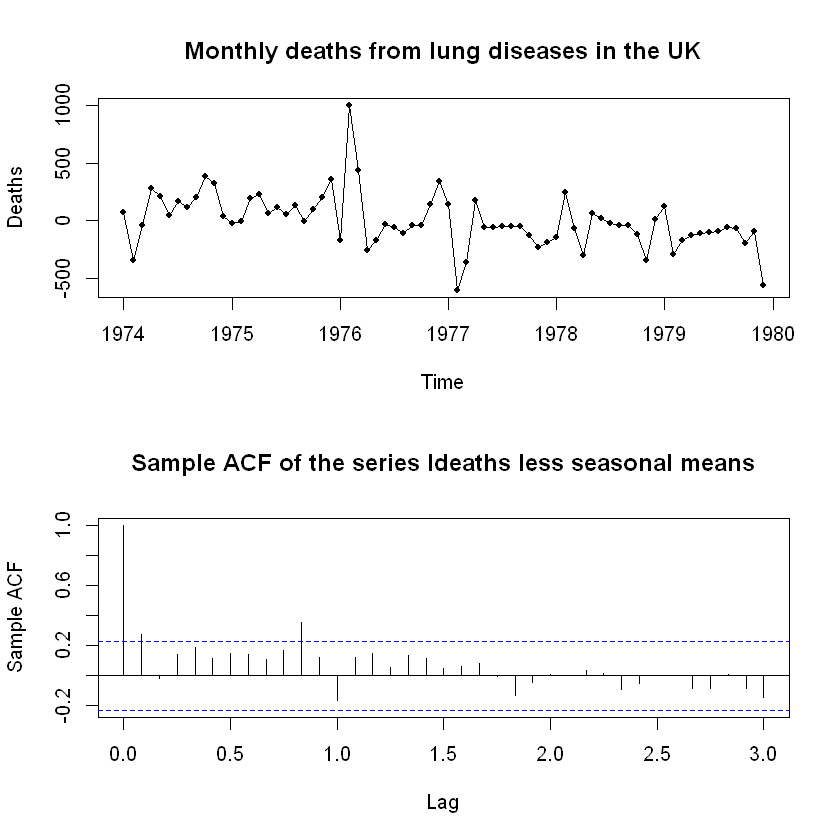

In [15]:
# Subtract each month in ldeaths by their respective means
yt = ldeaths - xbars$value

# Plot ldeaths after subtracting seasonal means 
par(mfrow=c(2, 1))
plot(yt, main="Monthly deaths from lung diseases in the UK", ylab="Deaths")
points(yt, pch=20)
acf(yt, main="Sample ACF of the series ldeaths less seasonal means", ylab="Sample ACF", lag.max=36)
par(mfrow=c(1, 1))

## 4.4 In-built function for method of moving averages 

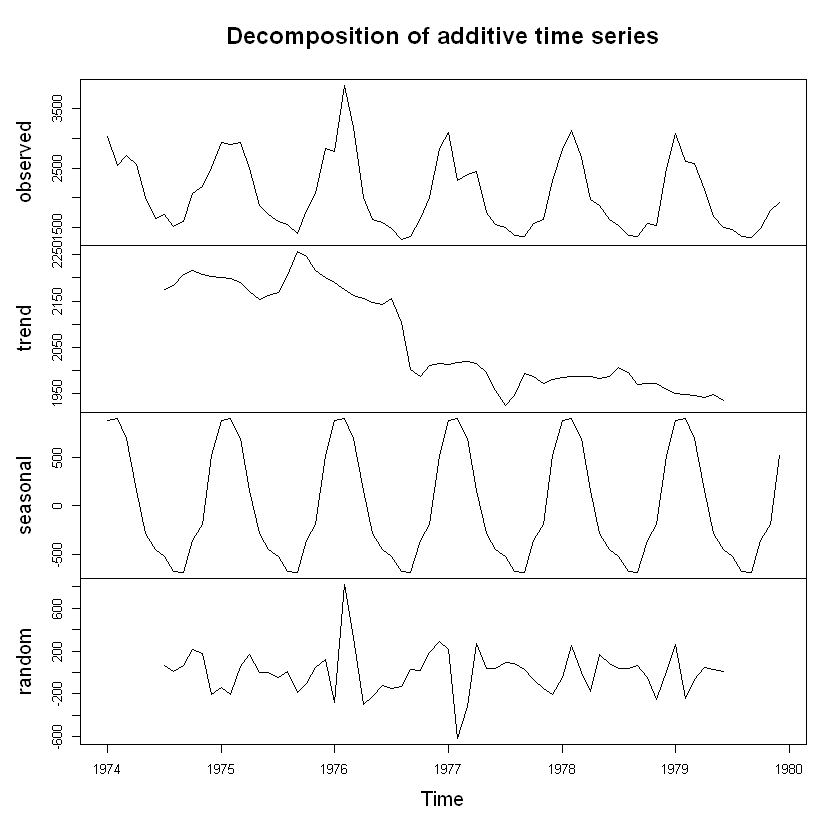

In [16]:
# Decompose ldeaths into its trend, seasonal and random components 
plot(decompose(ldeaths))

Trend and random components do not have the first and last 6 months of data. 

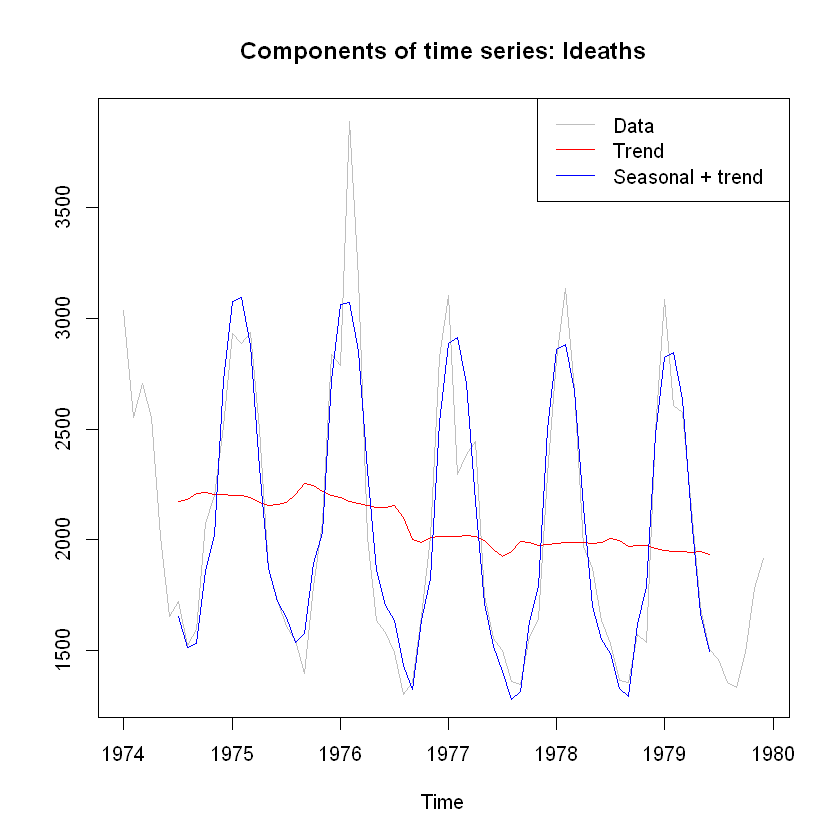

In [17]:
# Store trend, seasonal and random as individuals variables  
decomp = decompose(ldeaths) 
trend = decomp$trend
seasonal = decomp$seasonal
random = decomp$random

# Plot data, trend and seasonal + trend  
ts.plot(ldeaths, ylab="", main="Components of time series: ldeaths", col="grey")
lines(trend, col="red")
lines(seasonal+trend, col="blue")
legend("topright", legend=c("Data", "Trend", "Seasonal + trend"), col=c("grey", "red", "blue"), lty=1)

# 5. Model fitting 

We can estimate and choose the most appropriate ARIMA model for a time series based on its ACF and partial ACF plots. 

## 5.1 Choosing the right ARIMA model: Example 1

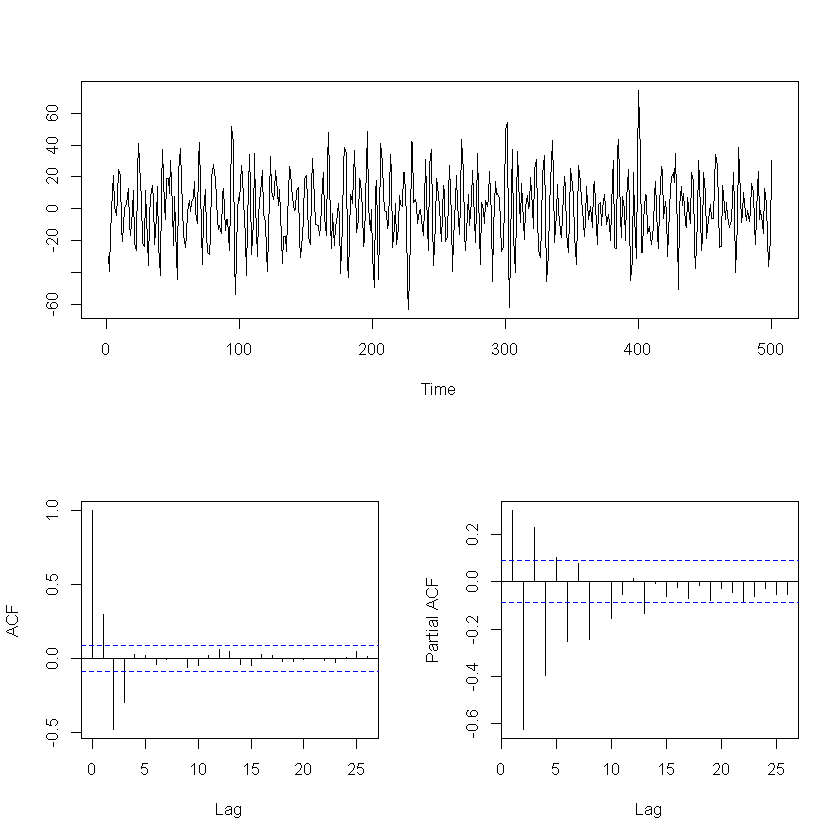

In [18]:
# Read time series data 
data = read.csv("fittingmodelEg1.csv", header=F)
data = ts(data[, 1])

# Plot data, ACF and partial ACF 
m = matrix(c(1, 1, 2, 3), 2, 2, byrow=TRUE)
layout(m)
ts.plot(data, ylab="")
acf(data,main="")
pacf(data,main="")
par(mfrow=c(1,1))

There is no obvious trend in the time series and variability appears to be reasonably constant.

ACF does not decrease slowly and therefore suggests that the process does not need to be differenced i.e. set d=0. ACF also drops suddenly inside the confidence interval after lag 3. Partial ACF, on the other hand, decays more gradually. 

So, we could try fitting a MA(3) model to this data, or equivalently, ARIMA(p=0, d=0, q=3). In practice, we would investigate multiple models before deciding on a final fit. 

## 5.2 Choosing the right ARIMA model: Example 2

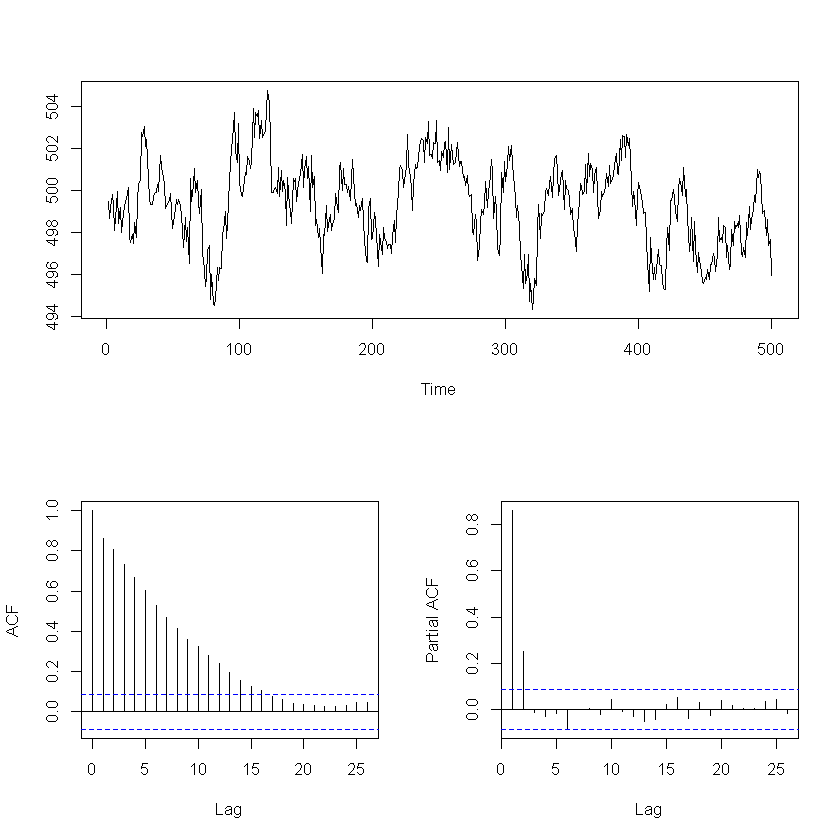

In [19]:
# Read time series data 
data2 = read.csv("fittingmodelEg2.csv", header=F)
data2 = ts(data2[, 1])

# Plot data, ACF and partial ACF 
m = matrix(c(1, 1, 2, 3), 2, 2, byrow=TRUE)
layout(m)
ts.plot(data2, ylab="")
acf(data2,main="")
pacf(data2,main="")
par(mfrow=c(1,1))

Similar to example 1, there is no obvious trend in the data itself, and the variable also appears to be reasonably constant over time. 

ACF does not show a steadily decreasing trend and so the data appears to be stationary and we can set d=0. The partial ACF, on the other hand, drops suddenly inside the confidence interval after lag 2. 

Therefore, we could try fitting an AR(2) model to this data, or equivalently, ARIMA(p=2, d=0, q=0). 

# 6. Testing the fit of a model

Here, I have outlined 3 methods to test the fit of a time series model: 
1. Graphs of residuals 
2. Ljung-Box test 
3. Akaike Information Criterion (AIC)

## 6.1 Graphs of residuals 

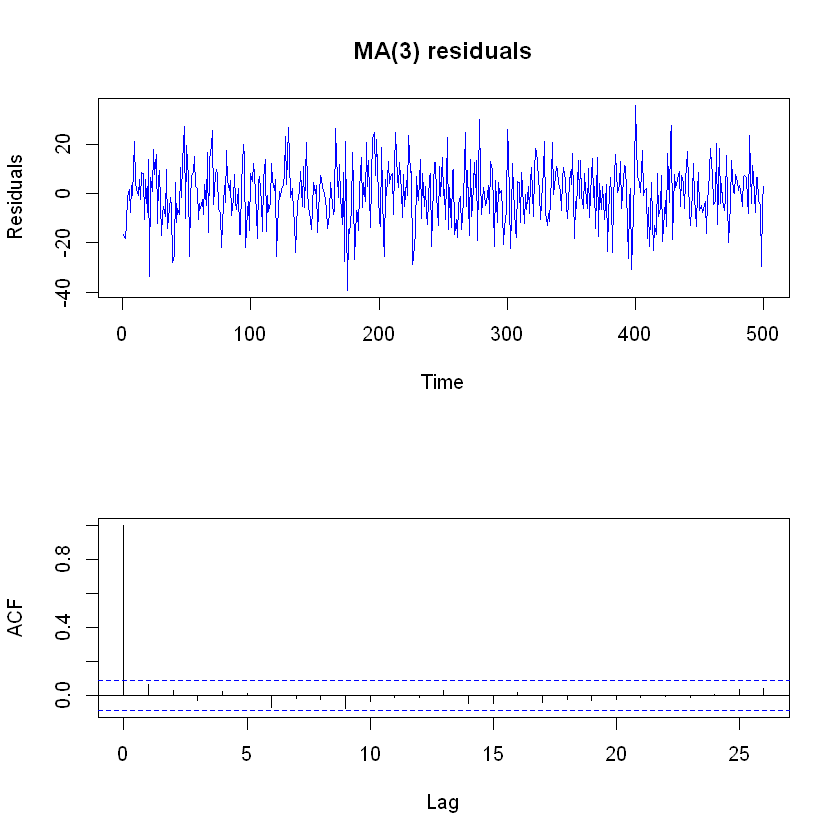

In [20]:
# Fit MA(3) model to data and extract residuals 
ma3 = arima(data, order=c(0, 0, 3))
residuals = ma3$residuals

# Plot residuals and ACF of residuals 
par(mfrow=c(2, 1))
ts.plot(residuals, main="MA(3) residuals", ylab="Residuals", col="blue")
acf(residuals, main="", ylab="ACF")
par(mfrow=c(1, 1))

The mean and variance of the residuals are broadly constant over time. The ACF of the residuals are all small with no significant patterns, and so the residuals appear to be independent.

We can conclude that the model is a good fit to the data. 

## 6.2 Ljung-Box test 

In [21]:
Box.test(residuals, lag=5, type="Ljung", fitdf=3)


	Box-Ljung test

data:  residuals
X-squared = 3.194, df = 2, p-value = 0.2025


Since p-value = 0.2025 > 0.05, we do not reject the null hypothesis and conclude that the model is a good fit to the data. 

Our choice of lag in the Ljung-Box test, in this case lag=5. The greater the correlation coefficient, the more likely the test statistic will follow a chi-squared distribution at the expense of a lower power of the test. 

Lag needs to also be greater than fitdf where fitdf = p+q from ARIMA(p, d, q) and since this is an MA(3) model, we have fitdf=0+3=3.  

## 6.3 Akaike Information Criterion (AIC) 

AIC is a measure of the trade-off between the goodness of fit of a model and the number of parameters in the model.

Although a model with many parameters might be a very good fit to the data, it will not necessarily be an accurate predictor of the future due to overfitting. Conversely, a model with too few parameters may not be sufficient to capture the significant patterns in the underlying data. 

Hence, a good model should strike a balance between these two effects and AIC helps us to objectively measure this.

Before we investigate how AIC works, let's determine an appropriate model for the data below. 

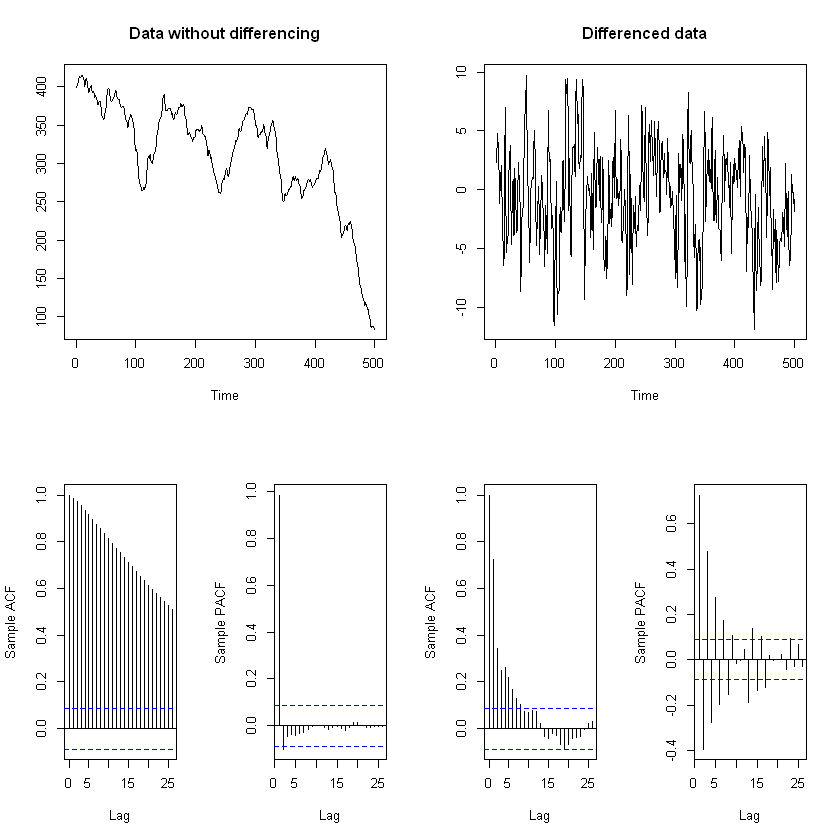

In [22]:
# Read time series data 
data3 = read.csv("fittingmodelEg3.csv", header=F)
data3 = ts(data3[, 1])

# Plot data without differencing and differenced data 
m = matrix(c(1, 1, 4, 4, 2, 3, 5, 6), 2, 4, byrow=TRUE)
layout(m)
ts.plot(data3, main="Data without differencing", ylab="")
acf(data3, main="", ylab="Sample ACF")
pacf(data3, main="", ylab="Sample PACF")
d = diff(data3)
ts.plot(d, main="Differenced data", ylab="")
acf(d, main="", ylab="Sample ACF")
pacf(d, main = "", ylab="Sample PACF")
par(mfrow=c(1, 1))

The left half of the display above indicates three plots relating to the original data. The data shows a clear downward trend and this is reflected in the sample ACF which is decaying slowly. This suggests that we need to difference the data, in order to remove its trend. 

The right half of the display relates to the differenced data, after differencing once. We can see that after differencing, we have removed the slow decay in the sample ACF.

So far, we know that our ARIMA model should be of ARIMA(p, d=1, q). To help us determine the values for p and q, we will deploy AIC. 

In [23]:
# Try values 0-2 for both p and q, record their respective AIC and put them into a data sframe 
aic.result = numeric(3)
for (p in 0:2) {
  for (q in 0:2) {
    aic = arima(d, order=c(p, 0, q))$aic
    aic.result = rbind(aic.result, c(p, q, aic))
  }
}
aic.result = aic.result[-1, ]
colnames(aic.result) = c("p", "q", "AIC")
aic.result

p,q,AIC
0,0,2823.290
0,1,2332.354
0,2,2069.906
1,0,2451.320
1,1,2188.086
1,2,2060.051
2,0,2369.651
2,1,2177.172
2,2,2053.419


We can see that p=2 and q=2 yield the lowest AIC, hence we should fit an ARIMA(2, 1, 2) model to the data. 

# 7. Forecasting using ARIMA model 

In [24]:
# Fit ARIMA(2, 0, 2) to differenced data, since data has already been differenced, we can set d=0 
fit = arima(d, order=c(2, 0, 2))
fit


Call:
arima(x = d, order = c(2, 0, 2))

Coefficients:
          ar1     ar2     ma1   ma2  intercept
      -0.1357  0.1321  1.8756  1.00    -0.6316
s.e.   0.0446  0.0449  0.0098  0.01     0.3188

sigma^2 estimated as 3.416:  log likelihood = -1020.71,  aic = 2053.42

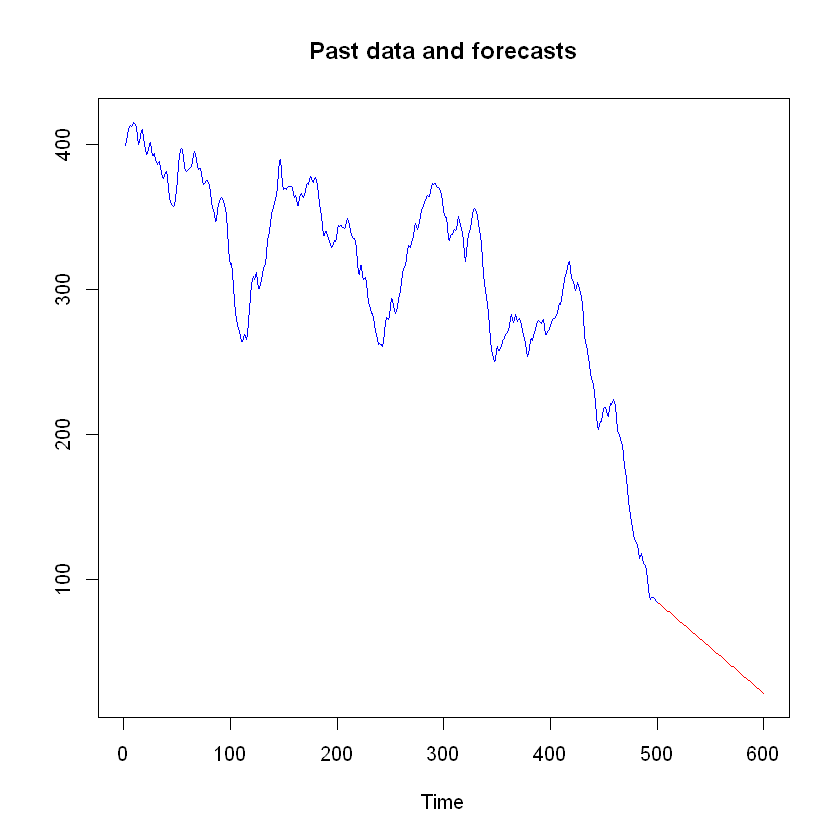

In [25]:
# Predict 100 steps ahead using ARIMA(2, 1, 2) model 
predictions = predict(fit, n.ahead=100)
predictions = predictions$pred

# Aggregate predictions with the final point of past data 
predictions.with.trend = tail(data3, 1) + cumsum(predictions)
predictions.with.trend = ts(predictions.with.trend, start=501, frequency=1)

# Plot past data and forecasts 
xlim = c(0, 600)
ylim = c(floor(min(data3, predictions.with.trend)), ceiling(max(data3, predictions.with.trend)))
ts.plot(data3, xlim=xlim, ylim=ylim, col="blue", main="Past data and forecasts", ylab="")
lines(predictions.with.trend, col="red")